In [ ]:
import os
import numpy as np
import pandas as pd

labels = [i for i in os.listdir('/content/drive/MyDrive/Adience_Processed')]
len(labels)

17058

In [ ]:
age = ['_'.join(i.split("_")[-3:-1]) for i in labels]
print(len(age))
print(set(age))
print(len(set(age)))

17058
{'45_45', '29_29', '32_32', '57_57', '46_46', '42_42', '22_22', '34_34', '36_36', '48_53', '58_58', '25_32', '8_23', '8_12', '55_55', '60_100', '0_2', '27_32', '56_56', '2_2', '4_6', '3_3', '23_23', '38_48', '13_13', '15_20', '38_43', '38_42', '35_35'}
29


In [ ]:
#(0-2, 4-6, 8-13, 15-20, 25-32, 38-43, 48-53, 60-)

In [ ]:
id = {0: '0-2', 1: '4-6', 2: '8-13', 3: '15-20', 4: '25-32', 5: '38-43', 6: '48-53', 7: '60-'}

def group_age(x):

  if x in ['0_2', '2_2', '3_3']:
    return 0
  elif x in ['4_6']:
    return 1
  elif x in ['13_13', '8_12']:
    return 2
  elif x in ['8_23', '15_20', '22_22']:
    return 3
  elif x in ['34_34', '29_29', '23_23', '27_32', '25_32', '32_32']:
    return 4
  elif x in ['35_35', '42_42', '38_48', '36_36', '38_43', '38_42']:
    return 5
  elif x in ['48_53', '46_46', '45_45', '55_55', '56_56']:
    return 6
  elif x in ['58_58', '57_57', '60_100']:
    return 7
  else:
    raise RuntimeError("Unexpected Age Value")


grouped_age = list(map(group_age, age))

In [ ]:
print(len(grouped_age))
print(set(grouped_age))
print(len(set(grouped_age)))

17058
{0, 1, 2, 3, 4, 5, 6, 7}
8


In [ ]:
print(len(labels))
print(len(grouped_age))

17058
17058


In [ ]:
df = pd.DataFrame()

df["file"] = labels
df["age"] = grouped_age

In [ ]:
del labels, age, grouped_age

In [ ]:
df.head()

,file,age
0,98_11305749136_8542463c0e_o_48_53_1.jpg,6
1,97_11305704915_c5319b90c9_o_0_2_1.jpg,0
2,97_11285988483_9bec8b6362_o_0_2_1.jpg,0
3,97_11285942746_d4586bae2f_o_0_2_1.jpg,0
4,99_11309939424_20896ac2fd_o_25_32_0.jpg,4


In [ ]:
ext = [i.split(".")[-1] for i in df['file']]
print(len(ext))
print(set(ext))

17058
{'jpg'}


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17058 entries, 0 to 17057
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    17058 non-null  object
 1   age     17058 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 266.7+ KB


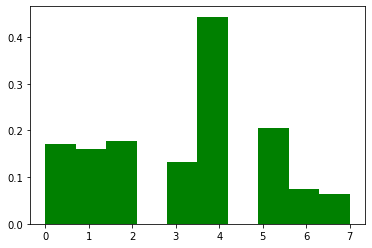

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df.age, density=True, color='g')
plt.show()

In [ ]:
df.age.value_counts().sort_index()

0    2049
1    1921
2    2121
3    1574
4    5297
5    2447
6     882
7     767
Name: age, dtype: int64

In [ ]:
!pip install -q tensorflow_addons

In [ ]:
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.metrics import Recall, Precision
import tensorflow as tf 
from tensorflow.keras import layers

In [ ]:
IMG_SIZE = 128

from PIL import Image
from tensorflow.keras.utils import to_categorical

class DataGenerator():
    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * 0.15)
        train_idx = p[:train_up_to]
        valid_idx = p[train_up_to:]
        
        return train_idx, valid_idx


    def norm(self, im):
        ma = np.max(im)
        mi = np.min(im)
        return (im - mi)/(ma - mi)
    
    def preprocess_image(self, img_path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        im = Image.open('/content/drive/MyDrive/Adience_Processed/' + img_path)
        im = im.resize((IMG_SIZE, IMG_SIZE))
        return self.norm(im)
        
    def get_labels(self, image_idx):

        labels = []
        for idx in image_idx:
            person = self.df.iloc[idx]
            labels.append(to_categorical(person['age'], 8))
        return labels
    
    
    def generate_images(self, image_idx, is_training, batch_size=16):
      
        # arrays to store our batched data
        images, ages = [], []
        while 1:
            for idx in image_idx:
                person = self.df.iloc[idx]
                
                age = person['age']
                fil = person['file']
                
                im = self.preprocess_image(fil)
                
                ages.append(to_categorical(age, 8))
                images.append(im)
                
                # yielding condition
                if len(images) >= batch_size:
                    yield np.array(images), [np.array(ages)]
                    images, ages = [], []
                    
            if not is_training:
                break
                
data_generator = DataGenerator(df)
valid_idx, train_idx = data_generator.generate_split_indexes()

In [ ]:
print(len(train_idx))
print(len(valid_idx))

14500
2558


In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  # layers.experimental.preprocessing.RandomZoom(-0.2, -0.2)
])

In [ ]:
base_model = EfficientNetB2(include_top=False)
regularizer = l2(0.03)

for layer in base_model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)

model = tf.keras.Sequential([
                             tf.keras.Input(shape = [IMG_SIZE, IMG_SIZE, 3]),
                            #  resize,
                             data_augmentation,
                             BatchNormalization(axis=3),
                             base_model,
                             GlobalAveragePooling2D(),
                             Dropout(0.45),
                             Dense(8, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 3)       12        
_________________________________________________________________
efficientnetb2 (Functional)  (None, None, None, 1408)  7768569   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 11272     
Total params: 7,779,853
Trainable params: 7,712,272
Non-trainable params: 67,581
_______________________________________

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(0.001, clipnorm=0.001),
  metrics=['categorical_accuracy', Recall(), Precision(), F1Score(8)]
)

In [ ]:
Model_name = "Adience_B2"
batch_size = 128
epochs = 25

train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
val_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=batch_size)

def step(epoch, lr):
    return lr * tf.math.exp(-0.2)

callbacks = [
    ModelCheckpoint(f"/content/drive/MyDrive/Adience/{Model_name}.h5", monitor='categorical_accuracy', save_best_only=True, verbose=1),
    LearningRateScheduler(step, verbose=1),
    EarlyStopping(monitor = 'categorical_accuracy', patience = 7, verbose = 1)
]

history = model.fit(train_gen,
                    steps_per_epoch=50,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_steps = 20,
                    validation_data=val_gen)

Epoch 1/25

Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.0008187308, shape=(), dtype=float32).
50/50 [==============================] - 758s 15s/step - loss: 1.8967 - categorical_accuracy: 0.2868 - recall: 0.0954 - precision: 0.5024 - f1_score: 0.2023 - val_loss: 2.3063 - val_categorical_accuracy: 0.1457 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1_score: 0.0318

Epoch 00001: categorical_accuracy improved from -inf to 0.36812, saving model to /content/drive/MyDrive/Adience/Adience_B2.h5
Epoch 2/25

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0006703201, shape=(), dtype=float32).
50/50 [==============================] - 544s 11s/step - loss: 1.3432 - categorical_accuracy: 0.4761 - recall: 0.2797 - precision: 0.6327 - f1_score: 0.3968 - val_loss: 2.6194 - val_categorical_accuracy: 0.0449 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1_score: 0.0107

Epoch 00002: categorical_accuracy improved from 0.36

In [ ]:
loss, acc, recall, precision, f1_score = model.evaluate(train_gen, verbose=0, steps = len(train_idx)//batch_size)
print("\nTraining \t Loss: {:.3}  Accuracy: {:.3}%  Recall: {:.3}%  Precision: {:.3}%  F1_Score: {:.3}%".format(loss, acc*100, recall*100, precision*100, max(f1_score)*100))

loss, acc, recall, precision, f1_score = model.evaluate(val_gen, verbose=0, steps = len(valid_idx)//batch_size)
print("\nTesting \t Loss: {:.3}  Accuracy: {:.3}%  Recall: {:.3}%  Precision: {:.3}%  F1_Score: {:.3}%".format(loss, acc*100, recall*100, precision*100, max(f1_score)*100))


Training 	 Loss: 0.28  Accuracy: 89.9%  Recall: 88.0%  Precision: 92.3%  F1_Score: 97.3%

Testing 	 Loss: 0.63  Accuracy: 78.3%  Recall: 75.9%  Precision: 81.1%  F1_Score: 92.1%


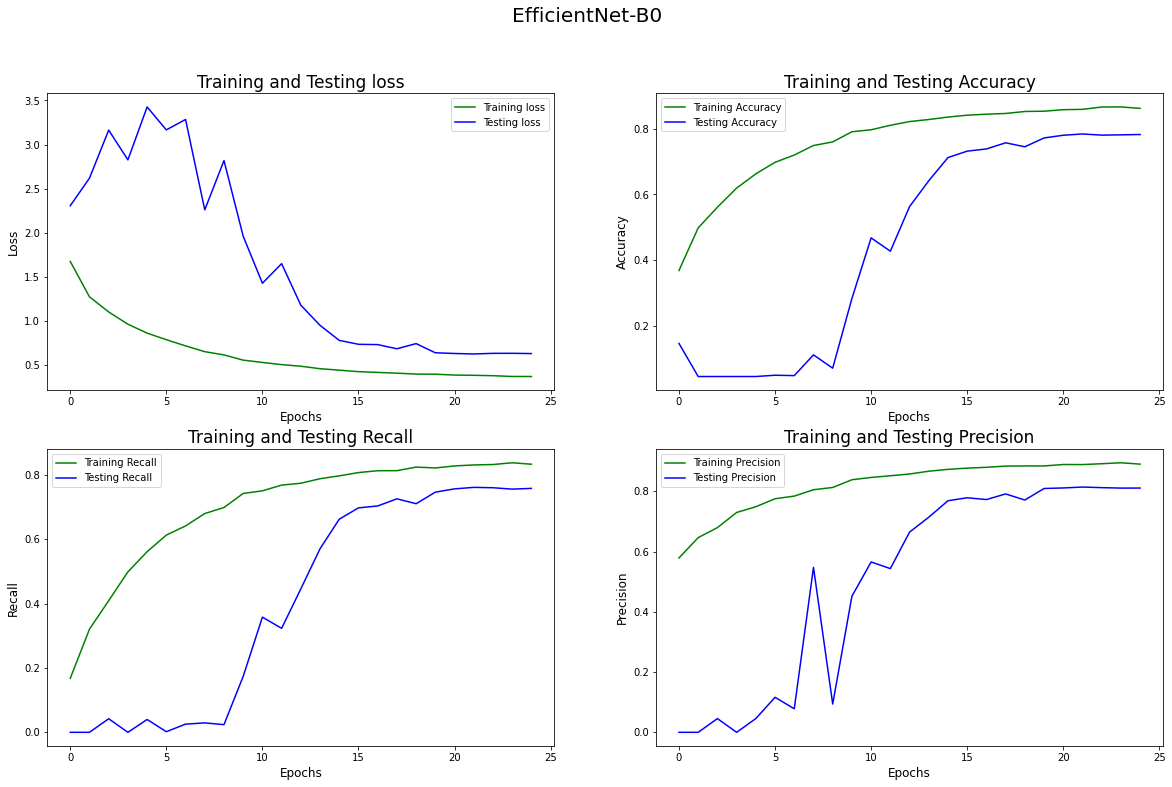

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(25))

plt.figure(figsize=(20,12))
plt.subplot(2, 2, 1)
plt.plot(epochs, history.history['loss'], 'g', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Testing loss')
plt.xlabel('Epochs', size=12)
plt.ylabel('Loss', size=12)
plt.title('Training and Testing loss', size=17)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, history.history['categorical_accuracy'], 'g', label='Training Accuracy')
plt.plot(epochs, history.history['val_categorical_accuracy'], 'b', label='Testing Accuracy')
plt.xlabel('Epochs', size=12)
plt.ylabel('Accuracy', size=12)
plt.title('Training and Testing Accuracy', size=17)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, history.history['recall'], 'g', label='Training Recall')
plt.plot(epochs, history.history['val_recall'], 'b', label='Testing Recall')
plt.xlabel('Epochs', size=12)
plt.ylabel('Recall', size=12)
plt.title('Training and Testing Recall', size=17)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, history.history['precision'], 'g', label='Training Precision')
plt.plot(epochs, history.history['val_precision'], 'b', label='Testing Precision')
plt.xlabel('Epochs', size=12)
plt.ylabel('Precision', size=12)
plt.title('Training and Testing Precision', size=17)
plt.legend()

plt.suptitle('EfficientNet-B0', size = 20)
plt.show()

### confusion matrix

In [ ]:
batch_size = 256
train_gen = data_generator.generate_images(train_idx, is_training=False, batch_size=batch_size)
val_gen = data_generator.generate_images(valid_idx[:2560], is_training=False, batch_size=batch_size)

In [ ]:
import tensorflow as tf
from tensorflow_addons.metrics import F1Score
from tensorflow.math import confusion_matrix

Model_name = "Adience_B2"
model = tf.keras.models.load_model(f'/content/drive/MyDrive/Adience/{Model_name}.h5', custom_objects={'f1_score':F1Score(8)})

In [ ]:
y_true = data_generator.get_labels(valid_idx[:2304])

In [ ]:
y_pred = model.predict(val_gen)
y_true = np.array(y_true)

In [ ]:
temp_y_pred = np.argmax(y_pred, axis=1)
temp_y_true = np.argmax(y_true, axis=1)

print(temp_y_pred.shape)
print(temp_y_true.shape)

(2304,)
(2304,)


In [ ]:
confusion_matrix(temp_y_true, temp_y_pred)

<tf.Tensor: shape=(8, 8), dtype=int32, numpy=
array([[252,  16,   0,   0,   2,   0,   0,   0],
       [ 22, 223,  23,   3,   2,   0,   0,   0],
       [  0,  18, 216,  19,  19,   2,   1,   0],
       [  0,   1,  11, 117,  41,   9,   1,   2],
       [  4,   6,  11,  40, 626,  55,   6,   1],
       [  1,   0,   7,  12,  71, 238,  14,   6],
       [  0,   0,   1,   0,   6,  15,  72,   7],
       [  0,   1,   1,   1,   6,  10,  23,  63]], dtype=int32)>